In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.dates import DateFormatter
from textblob import TextBlob
import os
import sys
import re
BASE_PATH = os.getcwd()
DATA_PATH = os.path.join(BASE_PATH, "data")
sys.path.insert(0, os.path.join(BASE_PATH))

In [10]:
def pow_column(data, col1, col2, newcolumn="pow"):
    data[newcolumn] = data[col1] * data[col2]
    return data

def round(data, num=4):
        return data.round(num)

class SentimentAnalysis:
    def __init__(self, data):
        self.data = data
        
    def _clean_text(self, text):
        PATTERNS = [
            '@[A-Za-z0–9]+',
            '#',
            'RT[\s]+',
            'https?:\/\/\S+'
        ]
        for pattern in PATTERNS:
            text = re.sub(pattern, '', text)
        return text
        
    def _get_subjectivity(self, text):
        return TextBlob(text).sentiment.subjectivity
    
    def _get_polarity(self, text):
        return TextBlob(text).sentiment.polarity
    
    def set_time_format(self, column='date', format='%Y-%m-%d'):
        self.data[column] = pd.to_datetime(self.data[column]).dt.strftime(format)
        return self
    
    def count_subjectivity(self, column):
        self.data['subjectivity'] = self.data[column].apply(self._get_subjectivity)
        return self
    
    def count_polarity(self, column):
        self.data['polarity'] = self.data[column].apply(self._get_polarity)
        return self
    
    def clean_text(self, column):
        self.data[column] = self.data[column].apply(self._clean_text)
        return self
    
    def get_full_data(self):
        return self.data
    
    def rebuild_time_series(self, column='date'):
        self.data = self.data.groupby([column], as_index=False).mean()
        idx = pd.date_range(self.data[column].min(), self.data[column].max(), name=column)
        self.data[column] = pd.DatetimeIndex(self.data[column])
        self.data = self.data.set_index(column).reindex(idx).reset_index()
        return self
    
    def interpolate(self, method='linear'):
        self.data = self.data.interpolate(method)
        return self
    
    def group_by_time(self, column='date', freq='D'):
        self.data[column] = pd.to_datetime(self.data[column])
        return self.data.resample(freq, on=column).mean().reset_index()

In [11]:
class PrepareStockData:
    def __init__(self, data):
        self.data = data

    def rebuild_time_series(self, column):
        idx = pd.date_range(self.data[column].min(), self.data[column].max(), name=column)
        self.data[column] = pd.DatetimeIndex(self.data[column])
        self.data = self.data.set_index(column).reindex(idx).reset_index()
        return self

    def get_full_data(self):
        return self.data
    
    def get_columns(self, *args):
        self.data = self.data.filter(list(args))
        return self
    
    def interpolate(self):
        self.data = self.data.interpolate(method='linear', limit_direction='forward', axis=0)
        return self
    
    def group_by_time(self, column='date', freq='D'):
        self.data[column] = pd.to_datetime(self.data[column])
        result=self.data.resample(freq, on=column).mean().reset_index()
        return result

In [12]:
from pandas.core.dtypes.generic import ABCDataFrame, ABCIndexClass, ABCSeries

def compute_correlation(data1, data2, column1, column2, method='pearson'):
    store = {}
    if (isinstance(data1, ABCDataFrame) and isinstance(data2, ABCDataFrame)) is not True:
        raise ValueError("Input data must be DataFrame or Series")
        
    if (isinstance(column1,(list)) and isinstance(column2, (list))) is not True:
        raise ValueError("column1 && column2 must be type of tulp")
        
    for col in column2:
        if set(column1).issubset(data1.columns) and col in data2:
            store[col] = data1[column1].corrwith(data2[col], method=method)
    return store

def print_correlation_result(lst):
    for item in lst:
        print("%s\n%s\n" % (item, lst[item]))

In [13]:
# подгружаем дату
tsla_price = pd.read_csv(DATA_PATH+"/tsla_price.csv")
musk_tweets = pd.read_csv(
                    DATA_PATH+"/musk.csv",
                    sep=';',
                    usecols=['date', 'text'],
                    error_bad_lines=False,
                    skip_blank_lines=True,
                    keep_default_na=False,
                    infer_datetime_format=True,
                   )

prepared_data = SentimentAnalysis(musk_tweets)

musk_tweets_data = prepared_data.clean_text('text').count_polarity('text').count_subjectivity('text').set_time_format().rebuild_time_series().interpolate()
musk_tweets_data_m = musk_tweets_data.group_by_time('date','M')
musk_tweets_data_w = musk_tweets_data.group_by_time('date','W')
musk_tweets_data_d = musk_tweets_data.group_by_time('date','D')

pow_column(musk_tweets_data_m, 'polarity', 'subjectivity')
pow_column(musk_tweets_data_w, 'polarity', 'subjectivity')
pow_column(musk_tweets_data_d, 'polarity', 'subjectivity')

print(musk_tweets_data_d)
print(musk_tweets_data_w)
print(musk_tweets_data_m)


tsla_price_data = PrepareStockData(tsla_price)
tsla_price_data = tsla_price_data.get_columns('Date', 'Close', 'Low').rebuild_time_series('Date').interpolate()
#
tsla_price_data_d = tsla_price_data.group_by_time('Date','D')
#
tsla_price_data_w = tsla_price_data.group_by_time('Date','W')
#
tsla_price_data_m = tsla_price_data.group_by_time('Date','M')


result_correlation_default = compute_correlation(musk_tweets_data_m, tsla_price_data_m, ['polarity','pow', 'subjectivity'], ['Low', 'Close'])
result_correlation_spearman = compute_correlation(musk_tweets_data_m, tsla_price_data_m, ['polarity','pow', 'subjectivity'], ['Low', 'Close'], 'spearman')
result_correlation_kendall = compute_correlation(musk_tweets_data_m, tsla_price_data_m, ['polarity','pow', 'subjectivity'], ['Low', 'Close'], 'kendall')
print("Pearson correlation:\n")
print_correlation_result(result_correlation_default)
print("\n")
print("Spearman correlation:\n")
print_correlation_result(result_correlation_spearman)
print("\n")
print("Kendall correlation:\n")
print_correlation_result(result_correlation_kendall)
print("\n")

          date  polarity  subjectivity       pow
0   2019-01-07  0.356667      0.355313  0.126728
1   2019-01-08  0.000000      0.000000  0.000000
2   2019-01-09 -0.009071      0.135283 -0.001227
3   2019-01-10  0.153704      0.229630  0.035295
4   2019-01-11  0.129167      0.202778  0.026192
..         ...       ...           ...       ...
361 2020-01-03  0.244444      0.300926  0.073560
362 2020-01-04  0.275000      0.355556  0.097778
363 2020-01-05  0.425000      0.475000  0.201875
364 2020-01-06  0.212500      0.237500  0.050469
365 2020-01-07  0.000000      0.000000  0.000000

[366 rows x 4 columns]
         date  polarity  subjectivity       pow
0  2019-01-13  0.161495      0.208048  0.033599
1  2019-01-20  0.235702      0.544032  0.128229
2  2019-01-27  0.169915      0.343229  0.058320
3  2019-02-03  0.131353      0.370375  0.048650
4  2019-02-10  0.138749      0.385652  0.053509
5  2019-02-17  0.128613      0.257819  0.033159
6  2019-02-24  0.078283      0.328123  0.025687
7  2

In [14]:
class Plot:
    def __init__(
        self,
        ax1_data,
        *args,
        **kwargs
    ):
        self.param_defaults = {
            'xlabel': 'Time',
            'xlabel_fontsize':20,
            'y1_label': 'y1',
            'y2_label': 'y2',
            'title': None,
            'title_fontsize':20, 
            'freq': 'M',
            'format_time': '%Y-%m-%d',
            'figsize': (36,9),
            'dpi': 90,
            'grid': False,
            'axis1_color': 'tab:red',
            'axis2_color': 'tab:blue',
            'index': 'date',
            'column1': 'date',
            'column2': 'date',
            'legend' : True,
        }
        
        for (param, default) in self.param_defaults.items():
            setattr(self, param, kwargs.get(param, default))
            
    
        if args:
            ax1_data.columns = map(str.lower, ax1_data.columns)
            args[0].columns = map(str.lower, args[0].columns)
            time_union = pd.merge(ax1_data, args[0], on=[self.index], how='outer')
            x = time_union.date
        else:
            x = ax1_data.date
        
        y1 = ax1_data[self.column1]
        fig, ax1 = plt.subplots(
            1, 1,
            figsize=self.figsize,
            dpi=self.dpi
        )

        ax1.plot(x, y1, color=self.axis1_color,  label=self.column1)
        
        plt.grid(self.grid)
        if self.legend:
            ax1.legend(loc='upper right')
        
        ax1.set_xlabel(self.xlabel, fontsize=self.xlabel_fontsize)
        ax1.tick_params(axis='x', rotation=0, labelsize=12)
        ax1.set_ylabel(self.y1_label, color=self.axis1_color, fontsize=20)
        ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
        scalex = pd.date_range(x.min(), x.max(), freq=self.freq, name=self.index).strftime(self.format_time)
        ax1.set_xticks(scalex)
        ax1.set_xticklabels(scalex, rotation=90, fontdict={'fontsize':10})

        if args:
            y2 = args[0][self.column2]
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.plot(x, y2, color=self.axis2_color, label=self.column2)
            if self.legend:
                ax2.legend(loc='lower right')
            ax2.set_ylabel(self.y2_label, color=self.axis2_color, fontsize=20)
            ax2.tick_params(axis='y', labelcolor=self.axis2_color)
            ax2.set_title(self.title, fontsize=self.title_fontsize)

/home/rebuspixel/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


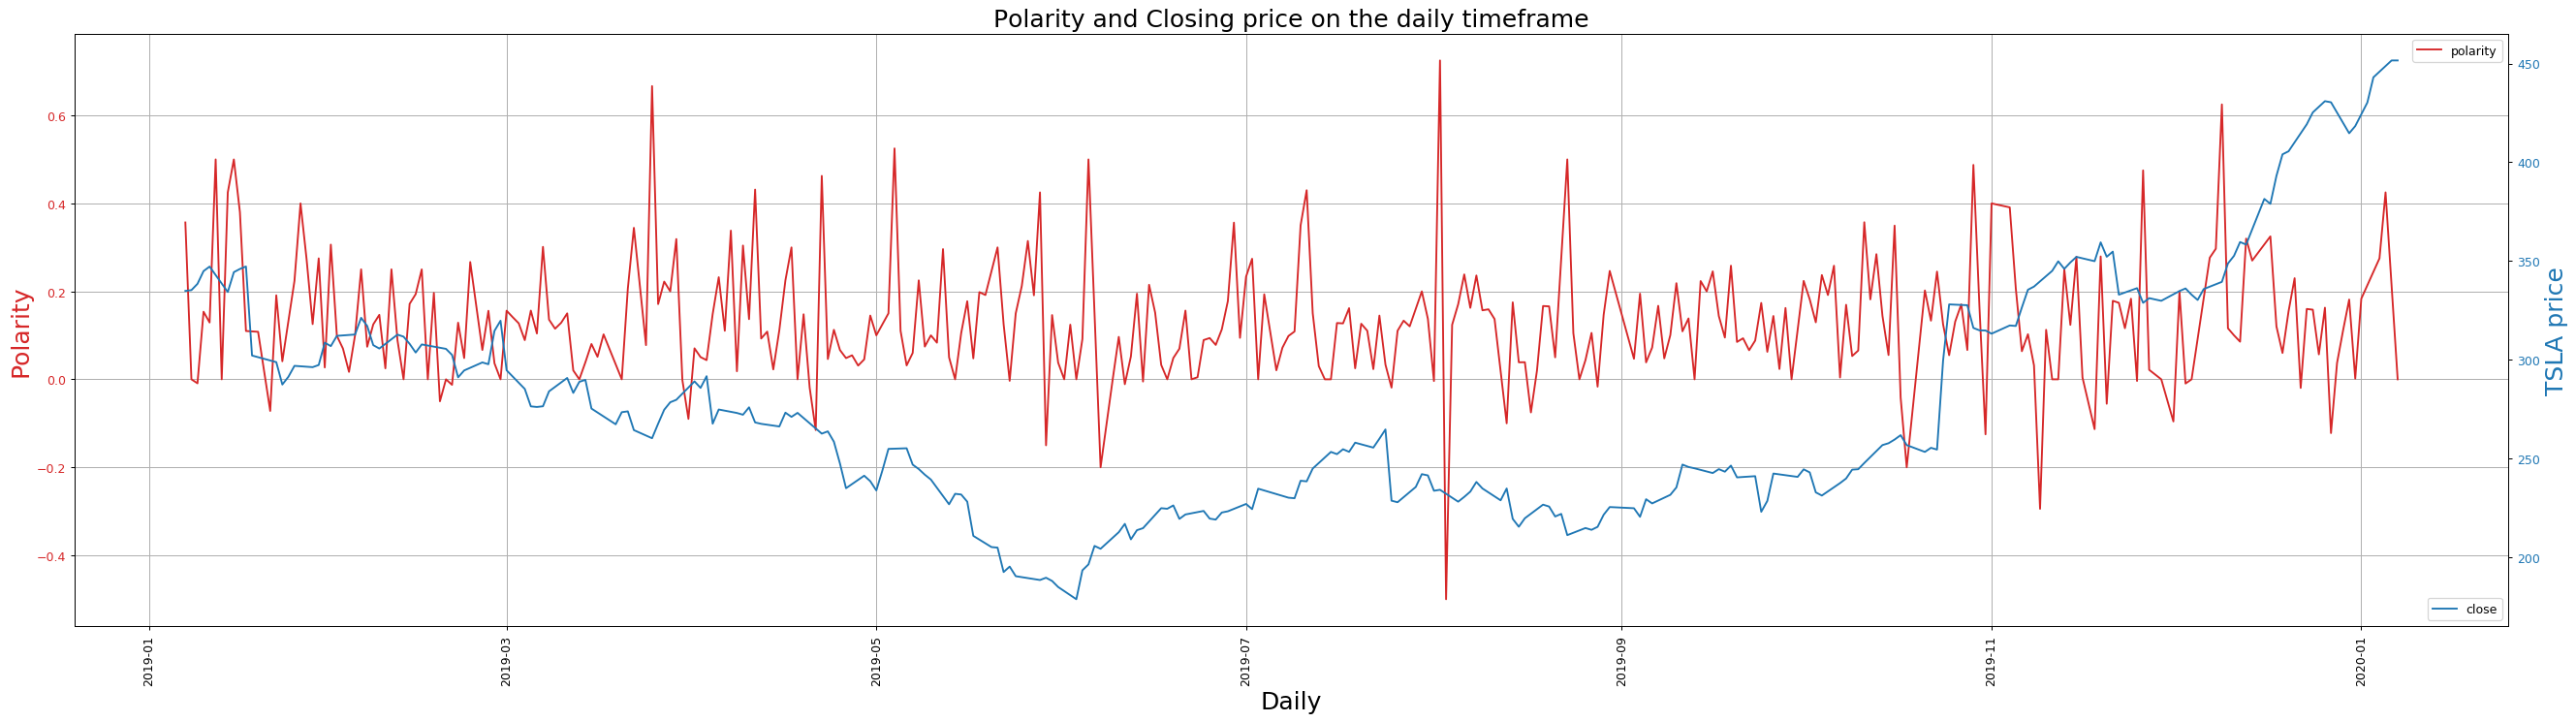

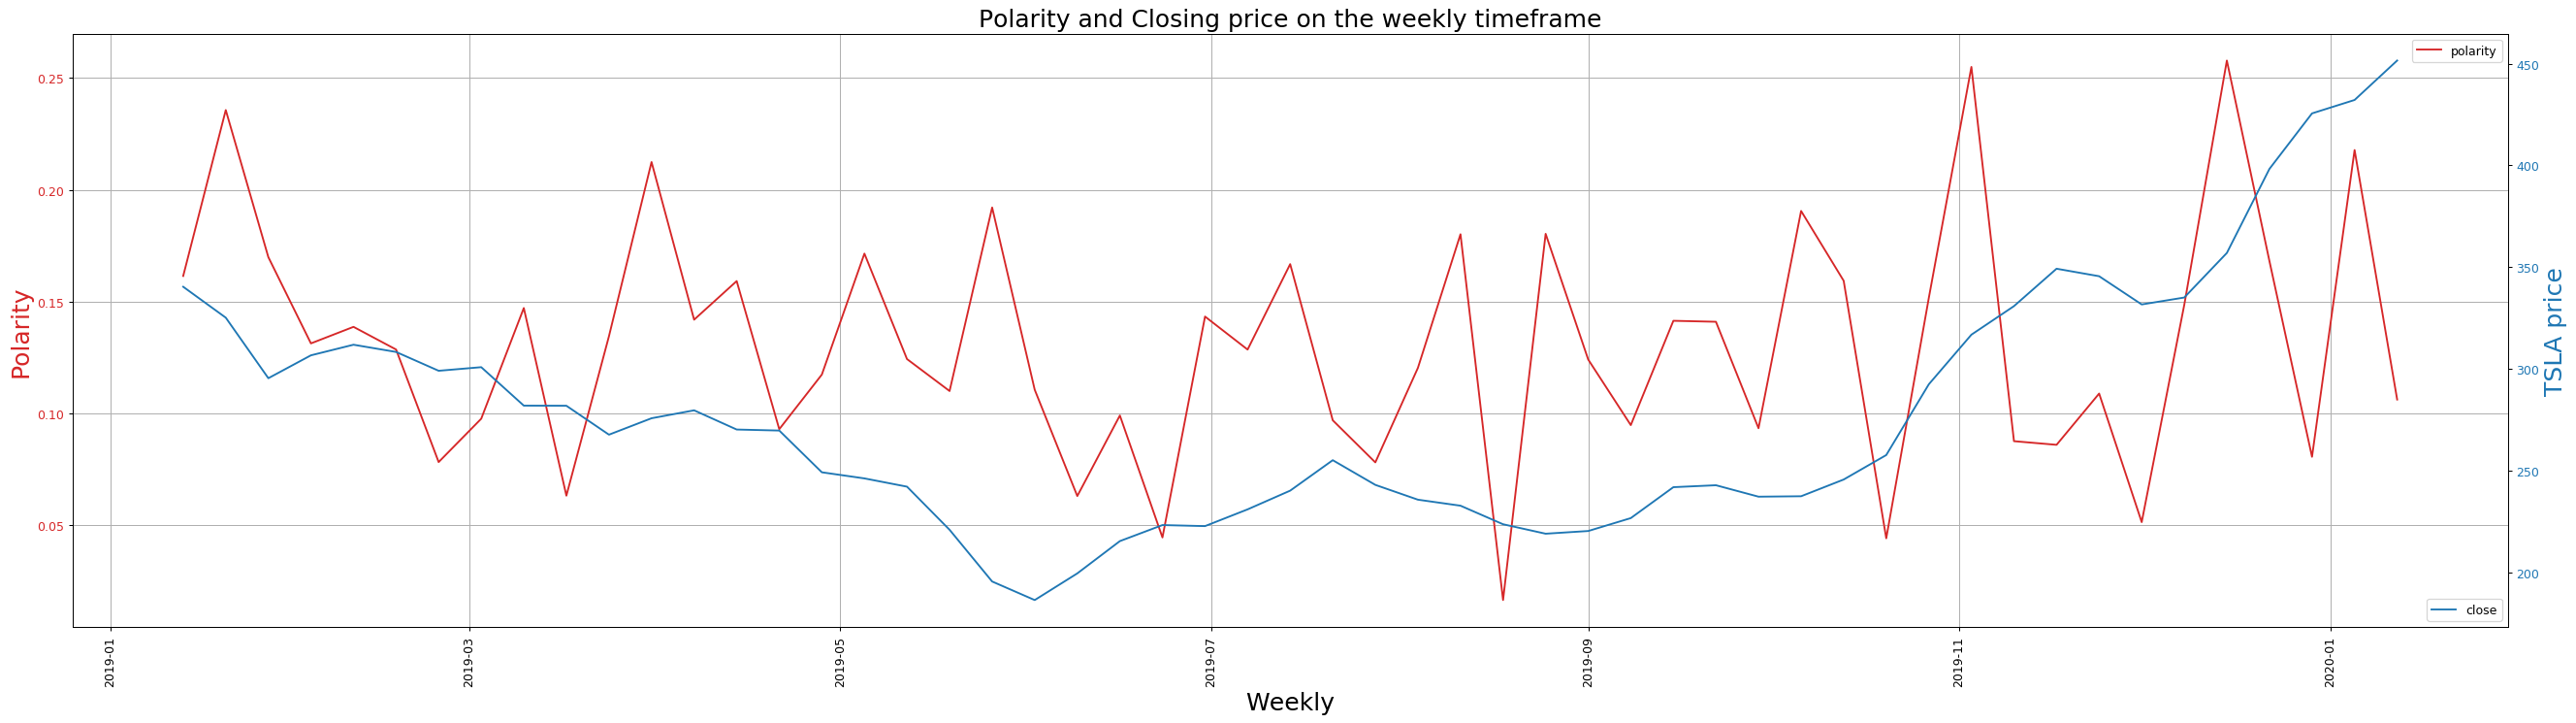

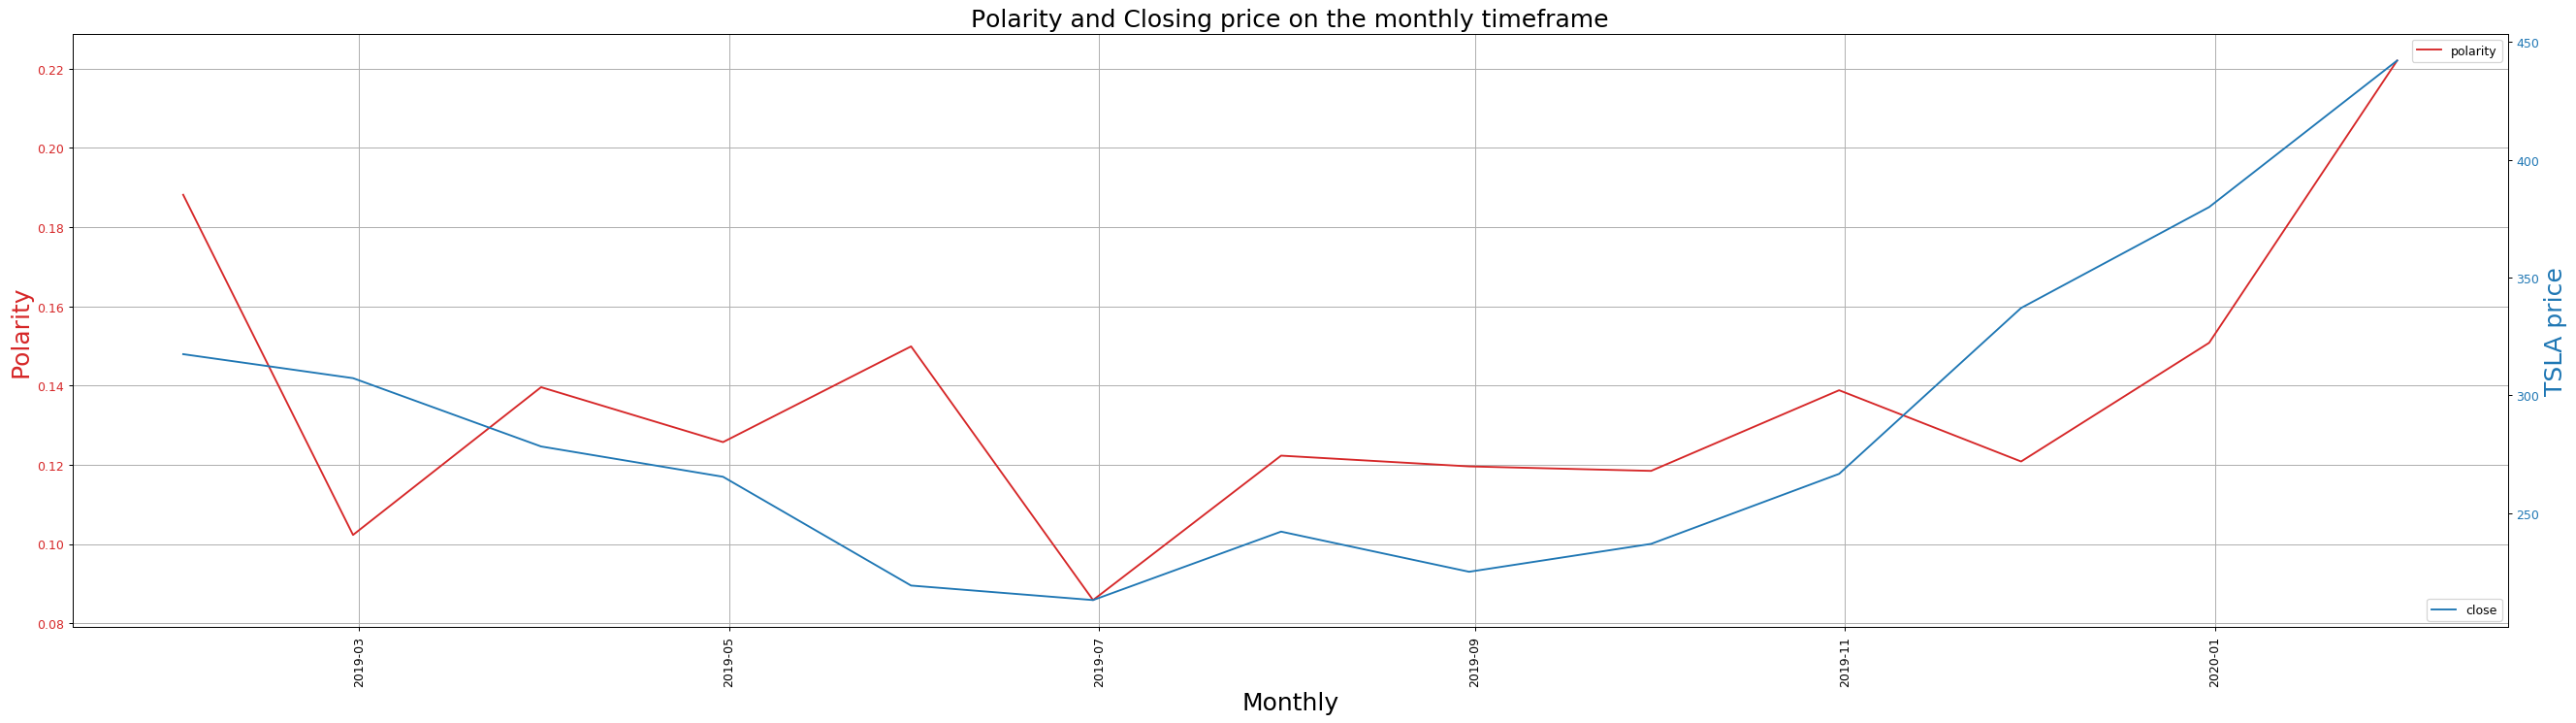

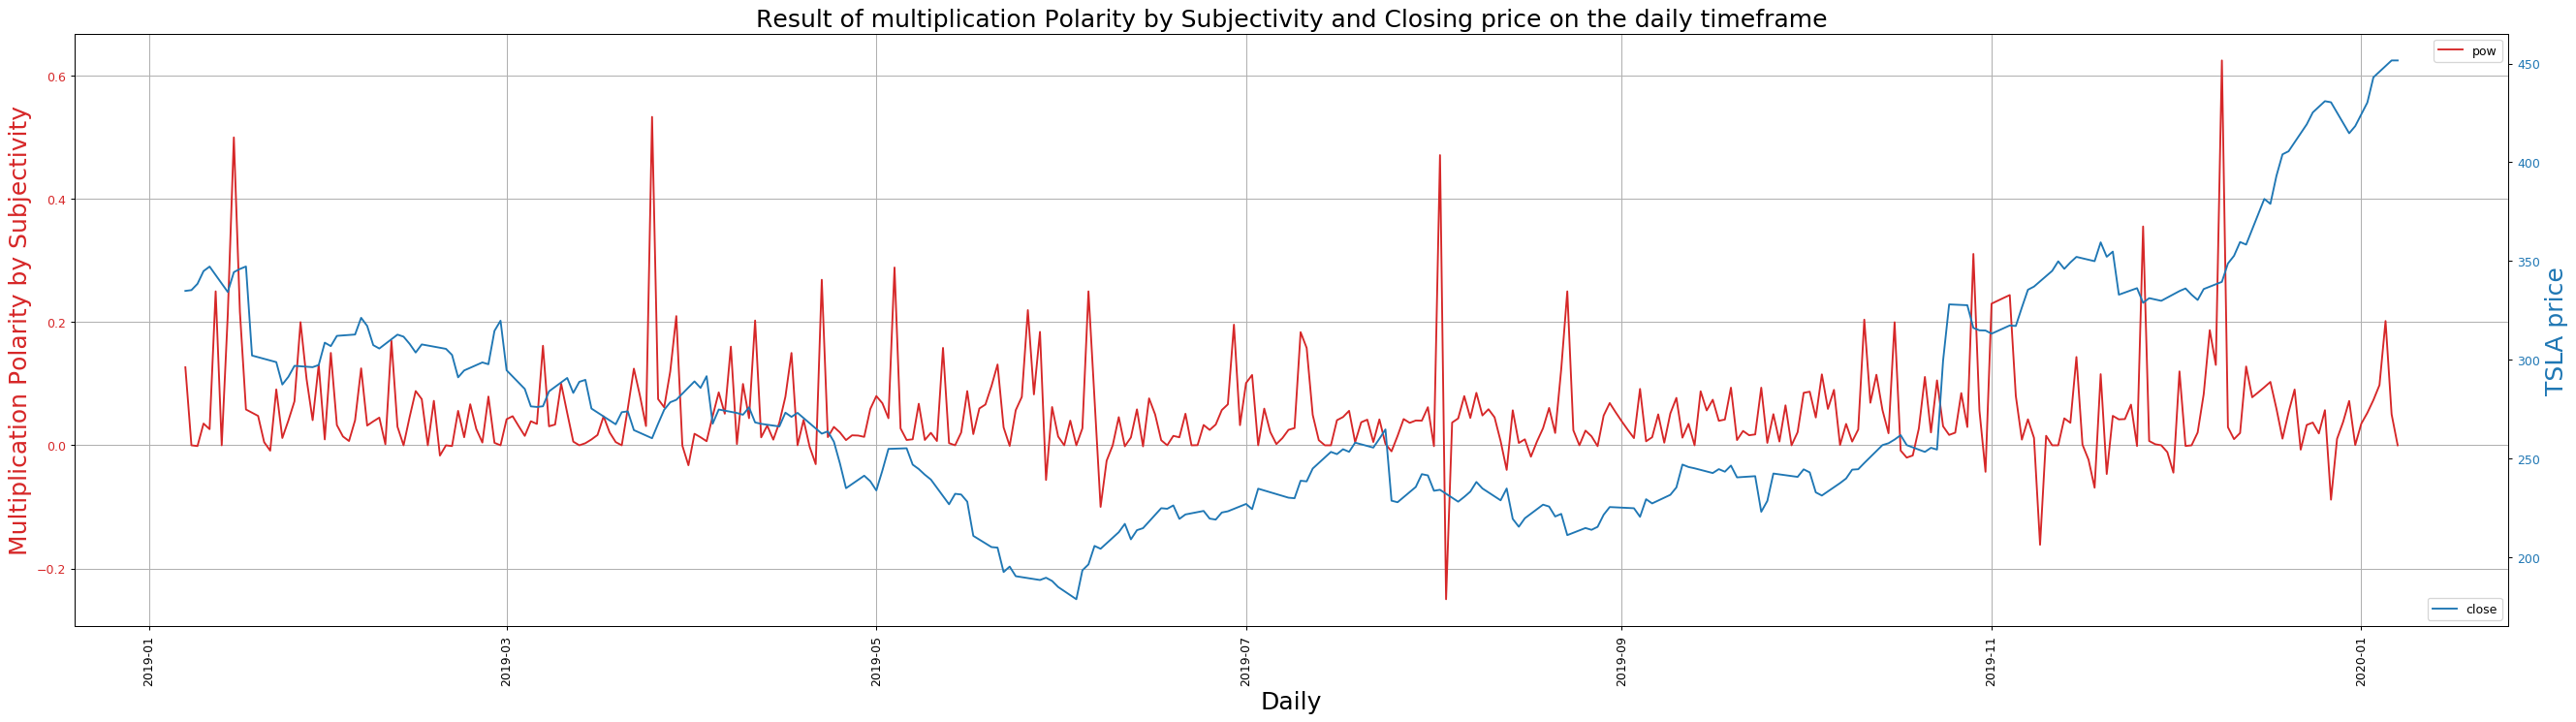

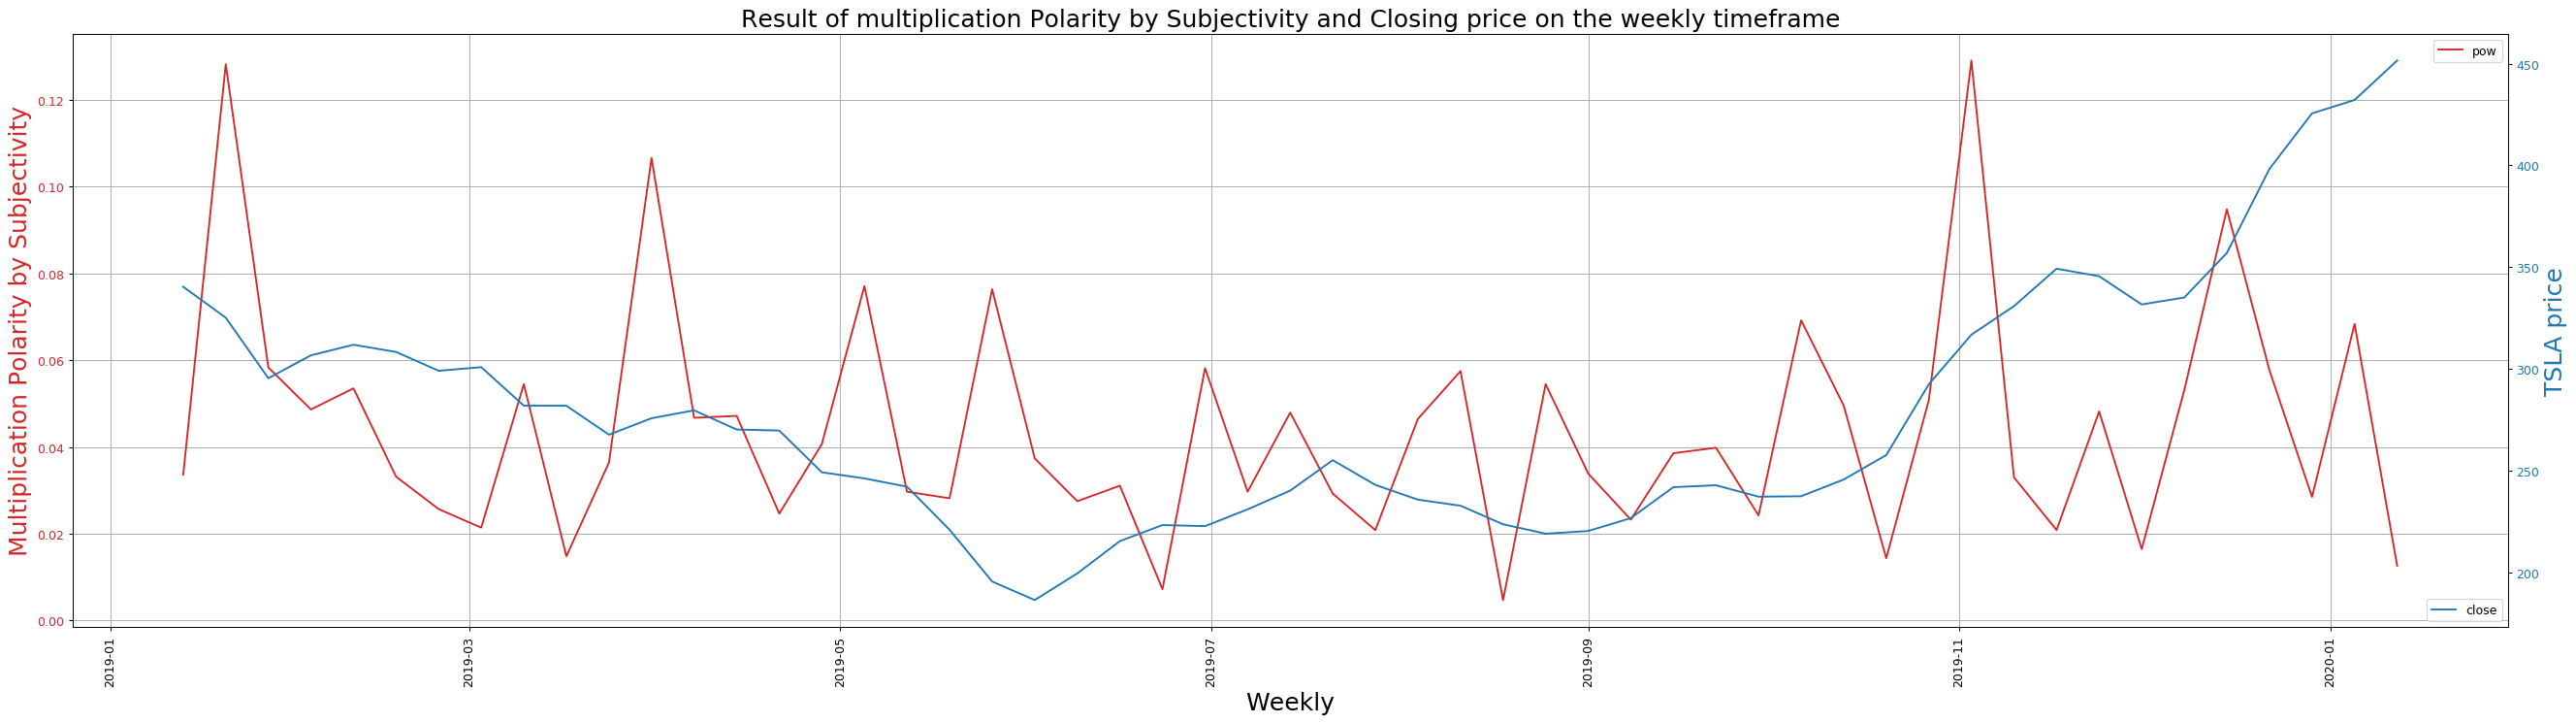

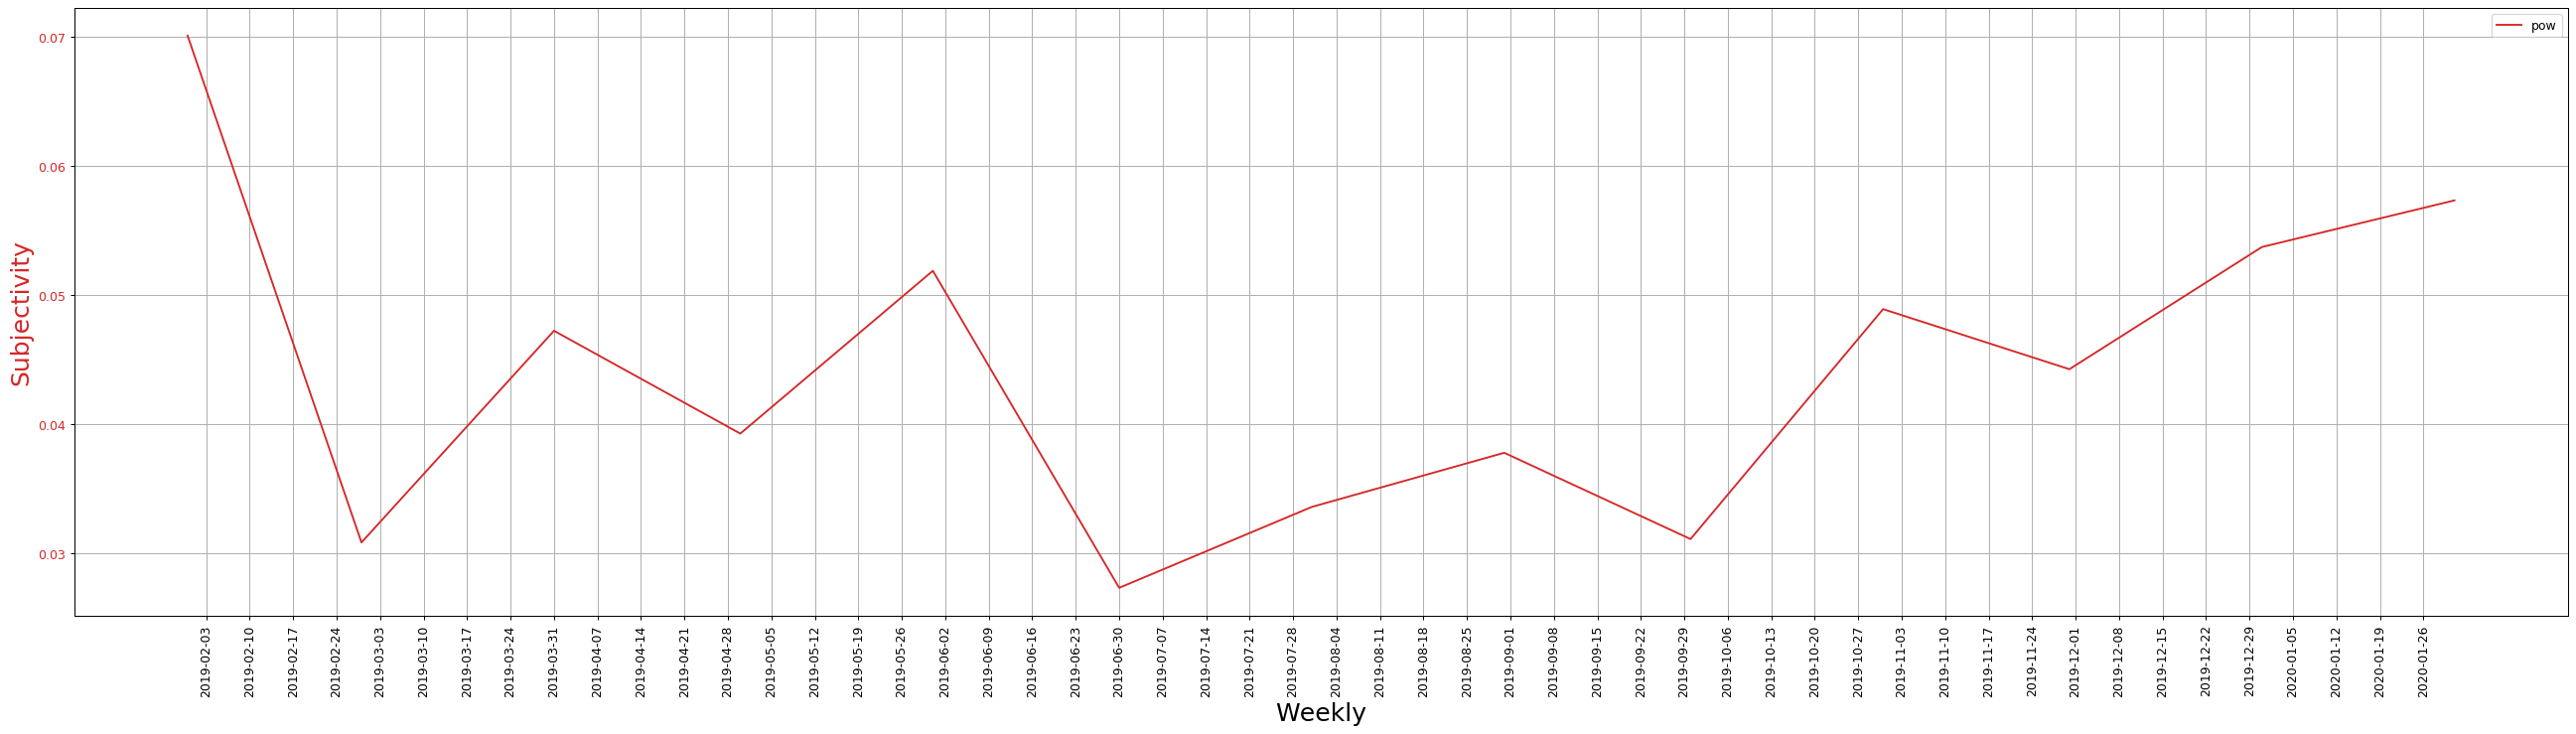

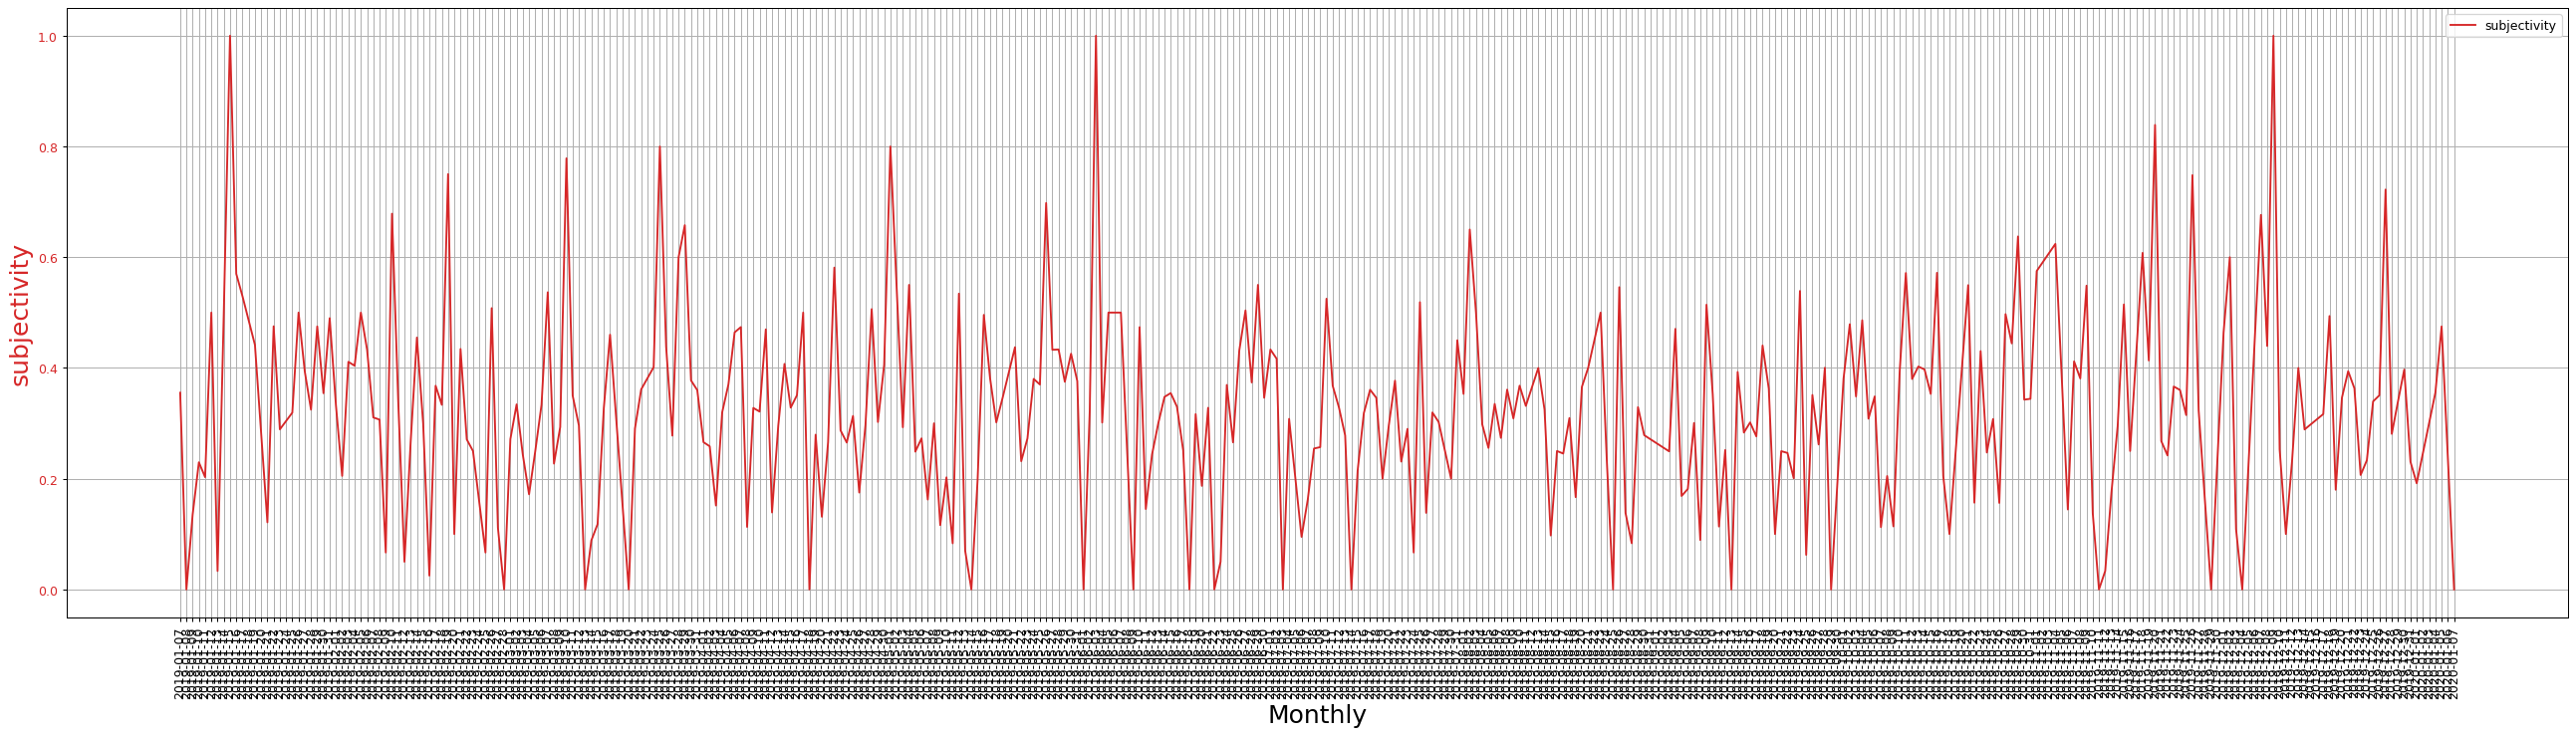

In [15]:
Plot(
    musk_tweets_data_d,
    tsla_price_data_d,
    column1='polarity',
    column2='close',
    freq='D',
    grid=True,
    xlabel='Daily',
    title='Polarity and Closing price on the daily timeframe',
    y1_label='Polarity',
    y2_label='TSLA price',
)

Plot(
    musk_tweets_data_w,
    tsla_price_data_w,
    column1='polarity',
    column2='close',
    freq='W',
    grid=True,
    xlabel='Weekly',
    title='Polarity and Closing price on the weekly timeframe',
    y1_label='Polarity',
    y2_label='TSLA price',
)

Plot(
    musk_tweets_data_m,
    tsla_price_data_m,
    column1='polarity',
    column2='close',
    freq='M',
    grid=True,
    xlabel='Monthly',
    title='Polarity and Closing price on the monthly timeframe',
    y1_label='Polarity',
    y2_label='TSLA price',
)

Plot(
    musk_tweets_data_d,
    tsla_price_data_d,
    column1='pow',
    column2='close',
    freq='D',
    grid=True,
    xlabel='Daily',
    title='Result of multiplication Polarity by Subjectivity and Closing price on the daily timeframe',
    y1_label='Multiplication Polarity by Subjectivity',
    y2_label='TSLA price',
)

Plot(
    musk_tweets_data_w,
    tsla_price_data_w,
    column1='pow',
    column2='close',
    freq='W',
    grid=True,
    xlabel='Weekly',
    title='Result of multiplication Polarity by Subjectivity and Closing price on the weekly timeframe',
    y1_label='Multiplication Polarity by Subjectivity',
    y2_label='TSLA price',
)

Plot(
    musk_tweets_data_m,
    column1='pow',
    freq='W',
    grid=True,
    xlabel='Weekly',
    title='Result of multiplication Polarity by Subjectivity on the monthly timeframe',
    y1_label='Subjectivity',
)

Plot(
    musk_tweets_data_d,
    column1='subjectivity',
    freq='D',
    grid=True,
    xlabel='Monthly',
    title='Subjectivity on the daily timeframe',
    y1_label='subjectivity',
)

In [16]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangercausality(*args, **kwargs):
    default_arguments = {
        'maxlag': 1,
        'verbose': True,
        'how_merge': 'outer',
    }
    
    columns = kwargs.get('columns')
    if len(columns) < 2:
        raise ValueError("missing 2 required positional arguments: columns") 
    if len(args) < 2:
        raise ValueError("missing 2 required positional arguments: left and right")
        
    for (param, default) in default_arguments.items():
        default_arguments[param] = kwargs.get(param, default)
        
    data = pd.merge(*args, how=default_arguments['how_merge']).filter(columns).pct_change().replace([np.inf, -np.inf]).dropna()
    
    return grangercausalitytests(data,
                                 maxlag=default_arguments['maxlag'],
                                 verbose=default_arguments['verbose']
                                )

In [24]:
grangercausality(tsla_price_data_d, musk_tweets_data_d, columns=['close', 'polarity'])
grangercausality(tsla_price_data_d, musk_tweets_data_d, columns=['close', 'pow'])
grangercausality(tsla_price_data_d, musk_tweets_data_d, columns=['close', 'subjectivity'])

grangercausality(tsla_price_data_w, musk_tweets_data_w, columns=['close', 'polarity'])
grangercausality(tsla_price_data_w, musk_tweets_data_w, columns=['close', 'pow'])
grangercausality(tsla_price_data_w, musk_tweets_data_w, columns=['close', 'subjectivity'])

grangercausality(tsla_price_data_m, musk_tweets_data_m, columns=['close', 'polarity'])
grangercausality(tsla_price_data_m, musk_tweets_data_m, columns=['close', 'pow'])
grangercausality(tsla_price_data_m, musk_tweets_data_m, columns=['close', 'subjectivity'])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3998  , p=0.5276  , df_denom=357, df_num=1
ssr based chi2 test:   chi2=0.4032  , p=0.5255  , df=1
likelihood ratio test: chi2=0.4029  , p=0.5256  , df=1
parameter F test:         F=0.3998  , p=0.5276  , df_denom=357, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1187  , p=0.7306  , df_denom=357, df_num=1
ssr based chi2 test:   chi2=0.1197  , p=0.7293  , df=1
likelihood ratio test: chi2=0.1197  , p=0.7294  , df=1
parameter F test:         F=0.1187  , p=0.7306  , df_denom=357, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4609  , p=0.0200  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=5.5063  , p=0.0189  , df=1
likelihood ratio test: chi2=5.4650  , p=0.0194  , df=1
parameter F test:         F=5.4609  , p=0.0200  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6549  , p=0.4224  

{1: ({'ssr_ftest': (3.2114064981346693, 0.11089354302597791, 8.0, 1),
   'ssr_chi2test': (4.41568393493517, 0.03561000082187487, 1),
   'lrtest': (3.712391712691293, 0.05400994727714833, 1),
   'params_ftest': (3.2114064981346684, 0.11089354302597798, 8.0, 1.0)},
   array([[0., 1., 0.]])])}